In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os as os
import sys as sys
import glob as glob
import re as re
import numpy as np
import shutil as shutil

import paprika
print(paprika.__version__)

from paprika.analysis import fe_calc
from paprika.restraints import DAT_restraint

import pytraj as pt
import parmed as pmd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2018-04-30_14:45:29_-0700-dff30ec-0.0.3


In [3]:
import logging
from importlib import reload
reload(logging)

logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %I:%M:%S %p',
                    level=logging.INFO)
logging.info('Started logging...')

2018-04-30 03:10:40 PM Started logging...


In [4]:
dummy_anchors = [':3', ':4', ':5']
host_anchors  = [':1@C26', ':1@C18', ':1@C8']
guest_anchors = [':2@C1', ':2@C3']

In [5]:
attach_string = '0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 ' \
                '18.10 24.40 37.00 49.60 74.80 100.00'
attach_fractions = [float(i) / 100 for i in attach_string.split()]

pull_string = '0.00 0.40 0.80 1.20 1.60 2.00 2.40 2.80 3.20 3.60 4.00 ' \
              '4.40 4.80 5.20 5.60 6.00 6.40 6.80 7.20 7.60 8.00 8.40 ' \
              '8.80 9.20 9.60 10.00 10.40 10.80 11.20 11.60 12.00 12.40 ' \
              '12.80 13.20 13.60 14.00 14.40 14.80 15.20 15.60 16.00 16.40 ' \
              '16.80 17.20 17.60 18.00'

windows = [len(attach_fractions), len(pull_string.split()), 0]

In [6]:
paths = glob.glob(os.path.normpath(os.path.join('./OA-G3-0', 'AMBER', 'APR', 'windows', '*')))

window_list = [os.path.basename(i) for i in paths]
phase_dict = {'a': 'attach', 'p': 'pull', 'r': 'release'}

In [12]:
g3_complexes = glob.glob('./OA-G3-*')
data = np.zeros((len(g3_complexes), 6))

In [18]:
for complex_index, complx in enumerate(sorted(g3_complexes)):

    print(complx)
    
    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]

    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)

    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')   
    
    fecalc = fe_calc()
    fecalc.prmtop = stripped.topology
    fecalc.trajectory = 'prod.*.nc'
    fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
    fecalc.restraint_list = guest_restraints
    fecalc.collect_data()
    fecalc.compute_free_energy()

    data[complex_index, 0] = complex_index
    data[complex_index, 1] = fecalc.results['attach']['mbar-block']['fe']
    data[complex_index, 2] = fecalc.results['attach']['mbar-block']['sem']
    data[complex_index, 3] = fecalc.results['pull']['mbar-block']['fe']
    data[complex_index, 4] = fecalc.results['pull']['mbar-block']['sem']
    
    
    # Analytic release
    
    fecalc.compute_ref_state_work([guest_restraints[0], guest_restraints[1], None, 
                                    None, guest_restraints[2], None])

    data[complex_index, 5] = fecalc.results['ref_state_work']
    
    print(f"{fecalc.results['attach']['mbar-block']['fe']} {fecalc.results['pull']['mbar-block']['fe']}")
    print(f"{fecalc.results['attach']['mbar-block']['n_frames']} frames analyzed...")
    print(f"{fecalc.results['pull']['mbar-block']['n_frames']} frames analyzed...")
    print(f"{fecalc.results['ref_state_work']}")

./OA-G3-0
Set pull offset (8.03 A)


2018-04-30 03:26:46 PM attach: computing convergence for mbar-blocking
2018-04-30 03:27:48 PM pull: computing convergence for mbar-blocking


3.8622819336022456 9.327554466604584
158000 frames analyzed...
460000 frames analyzed...
-7.045213819905932
./OA-G3-1
Set pull offset (5.63 A)


2018-04-30 03:28:01 PM attach: computing convergence for mbar-blocking
2018-04-30 03:29:03 PM pull: computing convergence for mbar-blocking


3.480092949041449 9.99228217625362
158000 frames analyzed...
460000 frames analyzed...
-7.160034219467988
./OA-G3-2
Set pull offset (7.28 A)


2018-04-30 03:29:15 PM attach: computing convergence for mbar-blocking
2018-04-30 03:30:11 PM pull: computing convergence for mbar-blocking


2.9326242185859197 10.396195882460578
158000 frames analyzed...
460000 frames analyzed...
-7.080123838744678
./OA-G3-3
Set pull offset (7.46 A)


2018-04-30 03:30:24 PM attach: computing convergence for mbar-blocking
2018-04-30 03:31:24 PM pull: computing convergence for mbar-blocking


2.9439684444023446 10.226869848860789
158000 frames analyzed...
460000 frames analyzed...
-7.071761750809843
./OA-G3-4
Set pull offset (6.83 A)


2018-04-30 03:31:38 PM attach: computing convergence for mbar-blocking
2018-04-30 03:32:37 PM pull: computing convergence for mbar-blocking


3.081065736229131 10.021257295051816
158000 frames analyzed...
460000 frames analyzed...
-7.100995030732292


[Text(0,0,'G0'),
 Text(0,0,'G1'),
 Text(0,0,'G2'),
 Text(0,0,'G3'),
 Text(0,0,'G4')]

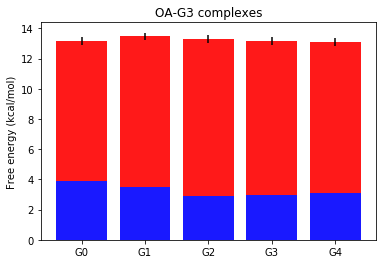

In [20]:
fig, ax = plt.subplots()
p1 = ax.bar(data[:,0], data[:,1], width=0.8, color='b', alpha=0.9, )

error = np.sqrt(data[:,2]**2 + data[:,4]**2)


p2 = ax.bar(data[:,0], data[:,3], width=0.8, bottom=data[:,1], color='r', alpha=0.9, 
           yerr=2 * error)

ax.set_ylabel('Free energy (kcal/mol)')
ax.set_title('OA-G3 complexes')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['G0', 'G1', 'G2', 'G3', 'G4'])

[Text(0,0,'G0'),
 Text(0,0,'G1'),
 Text(0,0,'G2'),
 Text(0,0,'G3'),
 Text(0,0,'G4')]

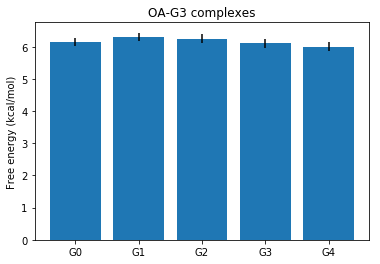

In [23]:
fig, ax = plt.subplots()

error = np.sqrt(data[:,2]**2 + data[:,4]**2)
p1 = ax.bar(data[:,0], data[:,1] + data[:,3] + data[:,5], yerr=error)

ax.set_ylabel('Free energy (kcal/mol)')
ax.set_title('OA-G3 complexes')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['G0', 'G1', 'G2', 'G3', 'G4'])

In [25]:
error

array([ 0.13626729,  0.12155648,  0.13402638,  0.1403968 ,  0.13028797])

## Uncertainty vs. simulation time for one complex...

In [219]:
fractions = np.arange(0.1, 1.1, 0.1)
data = np.zeros((len(fractions), 5))
complx = g3_complexes[0]

for fraction_index, fraction in enumerate(fractions):

    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]

    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                     [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                     [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                    ]

    guest_restraint_targets = [pull_initial,
                           180.0,
                           180.0
                          ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
               os.path.join(complx, 'AMBER', 'solvate.rst7'),
               structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)

    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                   os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')   

    fecalc = fe_calc()
    fecalc.prmtop = stripped.topology
    fecalc.trajectory = 'prod.*.nc'
    fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
    fecalc.restraint_list = guest_restraints
    fecalc.collect_data(fraction=fraction)
    fecalc.compute_free_energy()

    data[fraction_index, 0] = fraction
    data[fraction_index, 1] = fecalc.results['attach']['mbar-block']['fe']
    data[fraction_index, 2] = fecalc.results['attach']['mbar-block']['sem']
    data[fraction_index, 3] = fecalc.results['pull']['mbar-block']['fe']
    data[fraction_index, 4] = fecalc.results['pull']['mbar-block']['sem']

    print(f"{fecalc.results['attach']['mbar-block']['fe']} {fecalc.results['pull']['mbar-block']['fe']}")
    print(f"{fecalc.results['attach']['mbar-block']['n_frames']} frames analyzed...")
    print(f"{fecalc.results['pull']['mbar-block']['n_frames']} frames analyzed...")


2018-04-30 09:50:05 AM attach: computing convergence for mbar-blocking
2018-04-30 09:50:11 AM pull: computing convergence for mbar-blocking


2.9696296113258622 11.320310011055415
15000 frames analyzed...
46000 frames analyzed...


2018-04-30 09:50:15 AM attach: computing convergence for mbar-blocking
2018-04-30 09:50:30 AM pull: computing convergence for mbar-blocking


3.009046263049317 10.536941980675913
30000 frames analyzed...
92000 frames analyzed...


2018-04-30 09:50:35 AM attach: computing convergence for mbar-blocking
2018-04-30 09:50:57 AM pull: computing convergence for mbar-blocking


2.9665089439811716 10.467955371649094
45000 frames analyzed...
138000 frames analyzed...


2018-04-30 09:51:04 AM attach: computing convergence for mbar-blocking
2018-04-30 09:51:31 AM pull: computing convergence for mbar-blocking


2.956085774670433 10.269031010027994
60000 frames analyzed...
184000 frames analyzed...


2018-04-30 09:51:40 AM attach: computing convergence for mbar-blocking
2018-04-30 09:52:13 AM pull: computing convergence for mbar-blocking


2.9437383631905023 10.223247418832385
75000 frames analyzed...
230000 frames analyzed...


2018-04-30 09:52:23 AM attach: computing convergence for mbar-blocking
2018-04-30 09:53:02 AM pull: computing convergence for mbar-blocking


2.9449730738399373 10.235369273240723
90000 frames analyzed...
276000 frames analyzed...


2018-04-30 09:53:14 AM attach: computing convergence for mbar-blocking
2018-04-30 09:54:01 AM pull: computing convergence for mbar-blocking


2.9438738877969346 10.184093506934547
105000 frames analyzed...
322000 frames analyzed...


2018-04-30 09:54:16 AM attach: computing convergence for mbar-blocking
2018-04-30 09:55:14 AM pull: computing convergence for mbar-blocking


2.9339033324730726 10.15971555725317
120000 frames analyzed...
368000 frames analyzed...


2018-04-30 09:55:30 AM attach: computing convergence for mbar-blocking
2018-04-30 09:56:30 AM pull: computing convergence for mbar-blocking


2.9374457495927384 10.239283912291052
135000 frames analyzed...
414000 frames analyzed...


2018-04-30 09:56:44 AM attach: computing convergence for mbar-blocking
2018-04-30 09:57:43 AM pull: computing convergence for mbar-blocking


2.9432500980950107 10.226869848860753
150000 frames analyzed...
460000 frames analyzed...


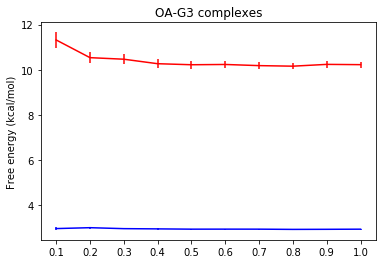

In [220]:
fig, ax = plt.subplots()
p1 = ax.errorbar(data[:,0], data[:,1], yerr=data[:,2], color='b')
p2 = ax.errorbar(data[:,0], data[:,3], yerr=data[:,4], color='r')

ax.set_ylabel('Free energy (kcal/mol)')
ax.set_title('OA-G3 complexes')
ax.set_xticks(fractions)
# ax.set_xticklabels(['G0', 'G1', 'G2', 'G3', 'G4'])

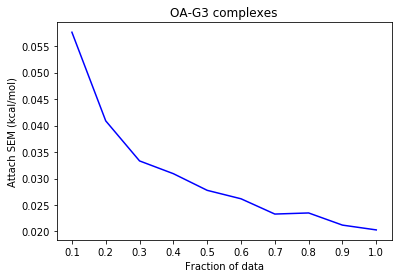

In [223]:
fig, ax = plt.subplots()
p1 = ax.errorbar(data[:,0], data[:,2], color='b')
# p2 = ax.errorbar(data[:,0], data[:,3], yerr=data[:,4], color='r')

ax.set_ylabel('Attach SEM (kcal/mol)')
ax.set_title('OA-G3 complexes')
ax.set_xticks(fractions)
ax.set_xlabel('Fraction of data')
# ax.set_xticklabels(['G0', 'G1', 'G2', 'G3', 'G4'])

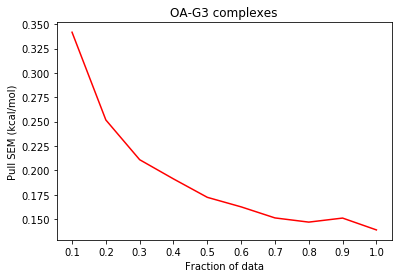

In [224]:
fig, ax = plt.subplots()
p1 = ax.errorbar(data[:,0], data[:,4], color='r')
# p2 = ax.errorbar(data[:,0], data[:,3], yerr=data[:,4], color='r')

ax.set_ylabel('Pull SEM (kcal/mol)')
ax.set_title('OA-G3 complexes')
ax.set_xticks(fractions)
ax.set_xlabel('Fraction of data')
# ax.set_xticklabels(['G0', 'G1', 'G2', 'G3', 'G4'])

# OA-G6 complexes

In [158]:
dummy_anchors = [':3', ':4', ':5']
host_anchors  = [':1@C26', ':1@C18', ':1@C8']
guest_anchors = [':2@C6', ':2@C1']

In [160]:
g6_complexes = glob.glob('./OA-G6*')
g6_data = np.zeros((len(g6_complexes), 5))

In [161]:
for complex_index, complx in enumerate(sorted(g6_complexes)):

    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]

    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)

    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')   
    
    fecalc = fe_calc()
    fecalc.prmtop = stripped.topology
    fecalc.trajectory = 'prod.*.nc'
    fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
    fecalc.restraint_list = guest_restraints
    fecalc.collect_data()
    fecalc.compute_free_energy()
    
    print(f"{fecalc.results['attach']['mbar-block']['fe']} {fecalc.results['pull']['mbar-block']['fe']}")

    g6_data[complex_index, 0] = complex_index
    g6_data[complex_index, 1] = fecalc.results['attach']['mbar-block']['fe']
    g6_data[complex_index, 2] = fecalc.results['attach']['mbar-block']['sem']
    g6_data[complex_index, 3] = fecalc.results['pull']['mbar-block']['fe']
    g6_data[complex_index, 4] = fecalc.results['pull']['mbar-block']['sem']

Set pull offset (9.98 A)


2018-04-26 11:43:42 AM attach: computing convergence for mbar-blocking
2018-04-26 11:44:05 AM pull: computing convergence for mbar-blocking


3.8189555600631233 9.890174438747081
Set pull offset (10.03 A)


2018-04-26 11:44:08 AM attach: computing convergence for mbar-blocking
2018-04-26 11:44:22 AM pull: computing convergence for mbar-blocking


3.689127156789846 10.264528708327488
Set pull offset (8.50 A)


2018-04-26 11:44:27 AM attach: computing convergence for mbar-blocking
2018-04-26 11:44:48 AM pull: computing convergence for mbar-blocking


4.161562242846581 9.593082852942368
Set pull offset (9.57 A)


2018-04-26 11:44:52 AM attach: computing convergence for mbar-blocking
2018-04-26 11:45:04 AM pull: computing convergence for mbar-blocking


3.8750843494071843 9.353403006175231
Set pull offset (9.06 A)


2018-04-26 11:45:08 AM attach: computing convergence for mbar-blocking
2018-04-26 11:45:27 AM pull: computing convergence for mbar-blocking


4.733234482217066 9.661921351649632


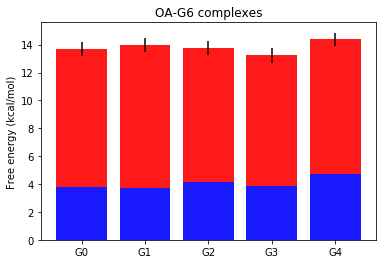

In [168]:
fig, ax = plt.subplots()
p1 = ax.bar(g6_data[:,0], g6_data[:,1], width=0.8, color='b', alpha=0.9, )

error = np.sqrt(g6_data[:,2]**2 + g6_data[:,4]**2)
p2 = ax.bar(g6_data[:,0], g6_data[:,3], width=0.8, bottom=g6_data[:,1], color='r', alpha=0.9, 
           yerr=2 * error)

ax.set_ylabel('Free energy (kcal/mol)')
ax.set_title('OA-G6 complexes')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['G0', 'G1', 'G2', 'G3', 'G4'])

## Analyze `prod.001.nc` and `prod.002.nc` in a list.

In [180]:
for complex_index, complx in enumerate(sorted(g6_complexes)):

    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]

    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)

    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')   
    
    fecalc = fe_calc()
    fecalc.prmtop = stripped.topology
    fecalc.trajectory = ['prod.001.nc', 'prod.002.nc']
    fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
    fecalc.restraint_list = guest_restraints
    fecalc.collect_data()
    fecalc.compute_free_energy()
    
    print(f"{fecalc.results['attach']['mbar-block']['fe']} {fecalc.results['pull']['mbar-block']['fe']}")
    print(f"{fecalc.results['attach']['mbar-block']['n_frames']} frames analyzed...")
    print(f"{fecalc.results['pull']['mbar-block']['n_frames']} frames analyzed...")
    g6_data[complex_index, 0] = complex_index
    g6_data[complex_index, 1] = fecalc.results['attach']['mbar-block']['fe']
    g6_data[complex_index, 2] = fecalc.results['attach']['mbar-block']['sem']
    g6_data[complex_index, 3] = fecalc.results['pull']['mbar-block']['fe']
    g6_data[complex_index, 4] = fecalc.results['pull']['mbar-block']['sem']

Set pull offset (9.98 A)


2018-04-27 01:34:17 PM attach: computing convergence for mbar-blocking
2018-04-27 01:34:48 PM pull: computing convergence for mbar-blocking


3.8144081712041347 9.792727141336831
60000 frames analyzed...
184000 frames analyzed...
Set pull offset (10.03 A)


2018-04-27 01:34:54 PM attach: computing convergence for mbar-blocking
2018-04-27 01:35:22 PM pull: computing convergence for mbar-blocking


3.6880693322220166 10.106236496389043
60000 frames analyzed...
184000 frames analyzed...
Set pull offset (8.50 A)


2018-04-27 01:35:28 PM attach: computing convergence for mbar-blocking
2018-04-27 01:35:59 PM pull: computing convergence for mbar-blocking


4.16156224284658 9.434221665443966
60000 frames analyzed...
184000 frames analyzed...
Set pull offset (9.57 A)


2018-04-27 01:36:05 PM attach: computing convergence for mbar-blocking
2018-04-27 01:36:39 PM pull: computing convergence for mbar-blocking


3.815388907644229 9.653046972038545
60000 frames analyzed...
184000 frames analyzed...
Set pull offset (9.06 A)


2018-04-27 01:36:46 PM attach: computing convergence for mbar-blocking
2018-04-27 01:37:18 PM pull: computing convergence for mbar-blocking


4.733234482217069 9.755691131773347
60000 frames analyzed...
184000 frames analyzed...


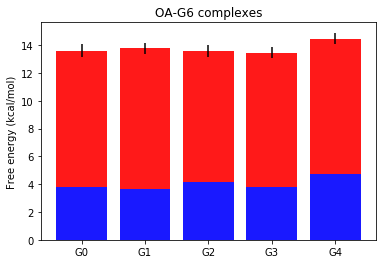

In [181]:
fig, ax = plt.subplots()
p1 = ax.bar(g6_data[:,0], g6_data[:,1], width=0.8, color='b', alpha=0.9, )

error = np.sqrt(g6_data[:,2]**2 + g6_data[:,4]**2)
p2 = ax.bar(g6_data[:,0], g6_data[:,3], width=0.8, bottom=g6_data[:,1], color='r', alpha=0.9, 
           yerr=2 * error)

ax.set_ylabel('Free energy (kcal/mol)')
ax.set_title('OA-G6 complexes')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['G0', 'G1', 'G2', 'G3', 'G4'])

In [185]:
g6_data[:,1]

array([ 3.81440817,  3.68806933,  4.16156224,  3.81538891,  4.73323448])

In [186]:
g6_data[:,2]

array([ 0.03802161,  0.03725589,  0.05088507,  0.0435127 ,  0.07013826])

## Analyze everything...

In [187]:
for complex_index, complx in enumerate(sorted(g6_complexes)):

    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]

    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)

    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')   
    
    fecalc = fe_calc()
    fecalc.prmtop = stripped.topology
    fecalc.trajectory = 'prod*.nc'
    fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
    fecalc.restraint_list = guest_restraints
    fecalc.collect_data()
    fecalc.compute_free_energy()
    
    print(f"{fecalc.results['attach']['mbar-block']['fe']} {fecalc.results['pull']['mbar-block']['fe']}")
    print(f"{fecalc.results['attach']['mbar-block']['n_frames']} frames analyzed...")
    print(f"{fecalc.results['pull']['mbar-block']['n_frames']} frames analyzed...")
    g6_data[complex_index, 0] = complex_index
    g6_data[complex_index, 1] = fecalc.results['attach']['mbar-block']['fe']
    g6_data[complex_index, 2] = fecalc.results['attach']['mbar-block']['sem']
    g6_data[complex_index, 3] = fecalc.results['pull']['mbar-block']['fe']
    g6_data[complex_index, 4] = fecalc.results['pull']['mbar-block']['sem']

Set pull offset (9.98 A)


2018-04-29 04:39:48 PM attach: computing convergence for mbar-blocking
2018-04-29 04:40:55 PM pull: computing convergence for mbar-blocking


3.7342437454220057 9.538067828793393
150000 frames analyzed...
460000 frames analyzed...
Set pull offset (10.03 A)


2018-04-29 04:41:11 PM attach: computing convergence for mbar-blocking
2018-04-29 04:42:13 PM pull: computing convergence for mbar-blocking


3.6890297580159297 10.036524165039754
150000 frames analyzed...
460000 frames analyzed...
Set pull offset (8.50 A)


2018-04-29 04:42:29 PM attach: computing convergence for mbar-blocking
2018-04-29 04:43:33 PM pull: computing convergence for mbar-blocking


4.092410498085889 9.375414027509619
150000 frames analyzed...
460000 frames analyzed...
Set pull offset (9.57 A)


2018-04-29 04:43:50 PM attach: computing convergence for mbar-blocking
2018-04-29 04:44:33 PM pull: computing convergence for mbar-blocking


3.7804344475813267 10.016821959941415
150000 frames analyzed...
288165 frames analyzed...
Set pull offset (9.06 A)


2018-04-29 04:44:46 PM attach: computing convergence for mbar-blocking
2018-04-29 04:45:14 PM pull: computing convergence for mbar-blocking


4.7332344822170676 9.75569113177313
60000 frames analyzed...
184000 frames analyzed...


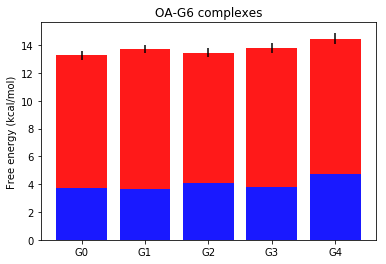

In [188]:
fig, ax = plt.subplots()
p1 = ax.bar(g6_data[:,0], g6_data[:,1], width=0.8, color='b', alpha=0.9, )

error = np.sqrt(g6_data[:,2]**2 + g6_data[:,4]**2)
p2 = ax.bar(g6_data[:,0], g6_data[:,3], width=0.8, bottom=g6_data[:,1], color='r', alpha=0.9, 
           yerr=2 * error)

ax.set_ylabel('Free energy (kcal/mol)')
ax.set_title('OA-G6 complexes')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['G0', 'G1', 'G2', 'G3', 'G4'])